In [1]:
import requests

import pandas as pd
import xgboost as xgb

# Functions

## Metric

In [2]:
def get_spearman_results(preds, y_test, ref):
    preds.rename({'target_r':'pred_r', 'target_g':'pred_g', 'target_b':'pred_b'}, axis=1, inplace=True)
    preds_ref = pd.concat([preds.reset_index(drop=True), ref.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
    spearman = pd.DataFrame()

    if 'pred_r' in preds.columns:
        spearman['target_r'] = preds_ref.groupby('Moons')[['pred_r','target_r']].corr(method='spearman').unstack().iloc[:,1]
    if 'pred_g' in preds.columns:
        spearman['target_g'] = preds_ref.groupby('Moons')[['pred_g','target_g']].corr(method='spearman').unstack().iloc[:,1]
    if 'pred_b' in preds.columns:
        spearman['target_b'] = preds_ref.groupby('Moons')[['pred_b','target_b']].corr(method='spearman').unstack().iloc[:,1]

    print(f'\nspearman score over the period :\n{spearman.describe()}\n')
    return spearman

## Modeling

In [3]:
def xg_boost_hackathon(X_train, X_test, y_train, target):
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=3, learning_rate=0.01, n_estimators=200, n_jobs=-1, colsample_bytree=0.7)
    model.fit(X_train, y_train[target])
    preds = model.predict(X_test)

    # return the model and the prediction so we can use the model afterward if we like it.
    return model, pd.DataFrame(preds, columns=[target])

In [4]:
# run modeling for each target
def modeling(X_train, X_test, y_train, targets):
    models_preds = pd.DataFrame()
    model = {}
    for target in targets:
        # you can change the model you want to use here.
        model[target], xgb_preds = xg_boost_hackathon(X_train, X_test, y_train, target)
        models_preds = pd.concat([models_preds, xgb_preds], axis=1)

    return model, models_preds

## Get proper data

In [5]:
# split the data, keep references of X_test, drop moons and id
def get_data(train_data, test_data, date_col_name="Moons", id_col_name="id"):
    y_train = train_data[[
        c for c in train_data.columns.to_list() if c.startswith('target')]].copy()
    y_test = test_data[[
        c for c in test_data.columns.to_list() if c.startswith('target')]].copy()
    X_train = train_data[[
        c for c in train_data.columns.to_list() if not c.startswith('target')]].copy()
    X_test = test_data[[
        c for c in test_data.columns.to_list() if not c.startswith('target')]].copy()

    # Keep references for the trailing X_test
    ref = X_test.loc[:, [id_col_name, date_col_name]].copy()

    X_train.drop(columns=[id_col_name, date_col_name], inplace=True)
    X_test.drop(columns=[id_col_name, date_col_name], inplace=True)

    return ref, X_train, y_train, X_test, y_test

## Walk forward function

In [6]:
def walk_forward_train_test(df,
                            date_col_name="Moons", 
                            id_col_name="id", 
                            rolling={'train':104, 'test':52}, 
                            embargo=13,
                            expanding_window=True,
                            targets=['target_r']):

    start_date = df[date_col_name].min() + rolling['train'] + embargo
    end_date = df[date_col_name].max()

    roll_spearman = pd.DataFrame()

    while start_date < end_date:
        if expanding_window:
            train_data = df[(df[date_col_name] < start_date - embargo)]                
        else:
            train_data = df[(df[date_col_name] < start_date - embargo) &
                            (df[date_col_name] > start_date - embargo - rolling['train'])]
        test_data = df[(df[date_col_name] > start_date) & 
                        (df[date_col_name] <= start_date + rolling['test'])]

        if test_data.empty == True:
            break

        print(f'\ntrain_data : {train_data[date_col_name].min()} - {train_data[date_col_name].max()}')
        print(f'test_data : {test_data[date_col_name].min()} - {test_data[date_col_name].max()}')

        # train/test split dataset and keep ref which are dates and barraid
        ref, X_train, y_train, X_test, y_test = get_data(train_data, test_data, date_col_name, id_col_name)

        # modeling
        model, model_preds = modeling(X_train, X_test, y_train, targets)

        # score
        spearman = get_spearman_results(model_preds, y_test, ref)
        roll_spearman = pd.concat([roll_spearman, spearman])

        # iter the next date
        start_date = start_date + rolling['test']


    return model, roll_spearman

# Start process

## Get the data

In [7]:
X_train = pd.read_csv('https://tournament.datacrunch.com/data/X_train.csv')
y_train = pd.read_csv('https://tournament.datacrunch.com/data/y_train.csv')
X_test = pd.read_csv('https://tournament.datacrunch.com/data/X_test.csv')

In [8]:
display(X_train, y_train, X_test)

,id,Moons,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28
0,000256eedc3ca251a86cee505364bc74,0,0.00,0.25,0.25,0.00,0.25,0.25,0.25,0.25,...,0.50,0.50,0.25,1.00,0.25,0.00,0.25,0.50,0.25,0.75
1,00663dca2cf251ffc20798834c8b49ca,0,1.00,0.50,0.75,0.75,0.75,0.75,0.75,0.75,...,0.50,0.50,0.25,0.50,0.25,0.00,0.25,1.00,0.25,0.50
2,006ee72c9c98a7b2a2f48cd735f7edd9,0,0.25,1.00,0.00,0.00,0.75,0.75,0.25,0.25,...,0.50,0.75,0.00,0.25,0.25,0.75,1.00,0.25,1.00,0.75
3,00767248c4e3475ff9777cc0fa2f245a,0,0.25,0.00,0.50,0.50,1.00,1.00,0.50,0.50,...,0.50,0.00,0.25,0.50,0.25,0.50,1.00,1.00,0.25,0.75
4,00789166277cac1fb682c1c8943ee3a5,0,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.50,1.00,0.25,0.75,0.25,0.75,0.25,0.50,0.25,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67892,ff61b736005cf8db10e1c0273bdb6c0d,28,1.00,1.00,0.00,0.50,0.75,0.75,0.50,0.50,...,0.25,0.00,0.25,1.00,1.00,1.00,0.75,0.50,0.25,0.50
67893,ff746625ad7d8a97b006c391dd6565e7,28,1.00,0.75,0.25,0.25,0.75,0.75,0.25,0.25,...,0.00,0.00,1.00,1.00,0.00,0.50,0.00,0.25,0.00,0.50
67894,ff936a839bd81b8e2712d41be3d33d60,28,1.00,1.00,1.00,0.25,0.00,0.00,0.75,0.75,...,0.25,1.00,1.00,0.25,0.00,0.50,0.25,0.25,1.00,0.25
67895,ffb55c266626e961a9dd79866a5ef00b,28,1.00,1.00,0.50,0.50,0.25,0.25,0.00,0.00,...,1.00,1.00,0.25,1.00,1.00,1.00,0.00,0.50,0.00,0.25


,target_r,target_g,target_b
0,0.25,0.50,0.25
1,0.25,0.25,0.75
2,0.75,0.50,0.75
3,0.25,0.25,0.25
4,0.75,1.00,1.00
...,...,...,...
67892,0.50,0.50,0.50
67893,0.25,0.00,0.25
67894,0.50,0.25,0.25
67895,0.00,0.50,0.25


,id,Moons,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28
0,0021949c0f40bf7b8de636d5557a36bd,0,1.00,0.75,0.75,0.75,0.50,0.0,0.75,0.0,...,1.00,1.00,0.00,0.75,0.25,0.75,0.25,0.00,1.00,0.75
1,0044a1eb91e6d9e766bfc070a58c091e,0,0.00,0.75,1.00,1.00,0.50,0.0,0.50,0.0,...,0.50,1.00,0.25,0.75,0.25,0.75,1.00,0.25,0.00,0.25
2,004b477e43f22d3eb0b7e318badb2438,0,0.00,0.00,0.75,0.75,0.25,0.0,0.25,0.0,...,0.50,0.50,0.25,0.00,0.25,0.00,0.25,1.00,0.25,1.00
3,005e227ee57221853cc374b5d5d79256,0,0.00,0.50,0.75,0.75,0.50,0.0,0.75,0.0,...,0.00,0.00,0.25,0.75,0.00,0.75,1.00,1.00,1.00,1.00
4,006b9832e7683a7ec2b6c3d177c4715a,0,0.00,1.00,0.75,0.75,0.25,0.0,0.25,0.0,...,0.25,1.00,0.25,0.75,0.00,0.75,0.25,0.25,0.75,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,ff9baadf910a626a35599a1c15ddb42a,0,0.75,1.00,0.50,0.50,0.25,1.0,1.00,1.0,...,0.00,0.50,0.00,0.50,0.00,0.25,1.00,0.50,0.75,0.75
2224,ffafd9c92b60f98962902f7cae7e3b66,0,0.50,0.25,0.00,0.00,0.75,1.0,0.75,1.0,...,1.00,0.25,1.00,0.25,1.00,0.00,0.00,1.00,0.75,1.00
2225,ffc01cf716931e050512a9a106150a40,0,1.00,0.50,0.00,0.00,0.75,1.0,0.00,1.0,...,0.00,0.75,1.00,0.00,0.00,0.00,0.75,0.25,0.75,0.25
2226,ffe524c3576df2a4b9cb3acd13fbb355,0,1.00,0.25,0.25,0.25,0.50,1.0,0.50,1.0,...,1.00,0.50,1.00,0.25,1.00,0.00,1.00,0.75,0.75,0.25


## Get targets names

In [9]:
# Targets columns
targets = y_train.columns[y_train.columns.str.startswith('target')]
targets

Index(['target_r', 'target_g', 'target_b'], dtype='object')

## Merge X_train and y_train

In [10]:
train_set = pd.merge(X_train, y_train[targets], left_index=True, right_index=True, how='inner')

In [18]:
train_set

,id,Moons,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,target_r,target_g,target_b
0,000256eedc3ca251a86cee505364bc74,0,0.00,0.25,0.25,0.00,0.25,0.25,0.25,0.25,...,1.00,0.25,0.00,0.25,0.50,0.25,0.75,0.25,0.50,0.25
1,00663dca2cf251ffc20798834c8b49ca,0,1.00,0.50,0.75,0.75,0.75,0.75,0.75,0.75,...,0.50,0.25,0.00,0.25,1.00,0.25,0.50,0.25,0.25,0.75
2,006ee72c9c98a7b2a2f48cd735f7edd9,0,0.25,1.00,0.00,0.00,0.75,0.75,0.25,0.25,...,0.25,0.25,0.75,1.00,0.25,1.00,0.75,0.75,0.50,0.75
3,00767248c4e3475ff9777cc0fa2f245a,0,0.25,0.00,0.50,0.50,1.00,1.00,0.50,0.50,...,0.50,0.25,0.50,1.00,1.00,0.25,0.75,0.25,0.25,0.25
4,00789166277cac1fb682c1c8943ee3a5,0,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.75,0.25,0.75,0.25,0.50,0.25,0.50,0.75,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67892,ff61b736005cf8db10e1c0273bdb6c0d,28,1.00,1.00,0.00,0.50,0.75,0.75,0.50,0.50,...,1.00,1.00,1.00,0.75,0.50,0.25,0.50,0.50,0.50,0.50
67893,ff746625ad7d8a97b006c391dd6565e7,28,1.00,0.75,0.25,0.25,0.75,0.75,0.25,0.25,...,1.00,0.00,0.50,0.00,0.25,0.00,0.50,0.25,0.00,0.25
67894,ff936a839bd81b8e2712d41be3d33d60,28,1.00,1.00,1.00,0.25,0.00,0.00,0.75,0.75,...,0.25,0.00,0.50,0.25,0.25,1.00,0.25,0.50,0.25,0.25
67895,ffb55c266626e961a9dd79866a5ef00b,28,1.00,1.00,0.50,0.50,0.25,0.25,0.00,0.00,...,1.00,1.00,1.00,0.00,0.50,0.00,0.25,0.00,0.50,0.25


## Get moon duration and adjust the rolling window and embargo

In [16]:
# Automatise moons retreival or set it yourself

apiKey = "" # <= API KEY HERE

session = requests.Session()
session.params.update({
    "apiKey": apiKey 
})
moon_duration = session.get("https://api.tournament.crunchdao.com/v2/rounds/@current/dataset-config").json()['moonsDuration'][1:]

# moon_duration = '30M'
moon_duration

'90D'

In [17]:
# Moon duration into days
moon_duration_dict = {
    '7D':7,
    '30D':30,
    '90D':90,
}

In [14]:
# rolling window for the train set. Default two years 
rolling_window_train = int((365 * 2) / moon_duration_dict[moon_duration])

# rolling window for the test set. Default one year
rolling_window_test = int((365) / moon_duration_dict[moon_duration])

# embargo of the length of the longest target. 
embargo = int((3 * 30) / moon_duration_dict[moon_duration])

## Run walk forward cross validation

In [19]:
model, spearman_cor_results = walk_forward_train_test(train_set,
                            date_col_name="Moons", 
                            id_col_name="id", 
                            rolling={'train':rolling_window_train, 'test':rolling_window_test},
                            embargo=embargo,
                            expanding_window=True,
                            targets=targets)


train_data : 0 - 7
test_data : 10 - 13

spearman score over the period :
       target_r  target_g  target_b
count  4.000000  4.000000  4.000000
mean   0.014744  0.017781  0.040253
std    0.028611  0.015269  0.016117
min   -0.026563  0.005070  0.023389
25%    0.006555  0.008273  0.033555
50%    0.025304  0.013338  0.037721
75%    0.033493  0.022847  0.044419
max    0.034932  0.039379  0.062182


train_data : 0 - 11
test_data : 14 - 17

spearman score over the period :
       target_r  target_g  target_b
count  4.000000  4.000000  4.000000
mean  -0.006022  0.009682  0.028872
std    0.019214  0.035165  0.025972
min   -0.029437 -0.026766 -0.007816
25%   -0.014404 -0.015707  0.019937
50%   -0.005875  0.008129  0.036708
75%    0.002507  0.033518  0.045644
max    0.017098  0.049234  0.049888


train_data : 0 - 15
test_data : 18 - 21

spearman score over the period :
       target_r  target_g  target_b
count  4.000000  4.000000  4.000000
mean   0.084410  0.079750  0.083342
std    0.026279  0

### Explore results

In [20]:
spearman_cor_results

,target_r,target_g,target_b
Moons,,,
10,0.017595,0.005070,0.038498
11,0.033013,0.017337,0.036944
12,0.034932,0.039379,0.062182
13,-0.026563,0.009340,0.023389
14,-0.009394,0.049234,0.049888
15,-0.002356,0.028280,0.044229
16,0.017098,-0.012021,0.029188
17,-0.029437,-0.026766,-0.007816
18,0.109985,0.118169,0.098201


In [21]:
spearman_cor_results.describe()

,target_r,target_g,target_b
count,19.000000,19.000000,19.000000
mean,0.025768,0.036216,0.047295
std,0.041637,0.037057,0.036241
min,-0.038966,-0.026766,-0.007816
25%,-0.003439,0.013338,0.022635
50%,0.029107,0.030622,0.038498
75%,0.045400,0.057918,0.065357
max,0.109985,0.118169,0.134421


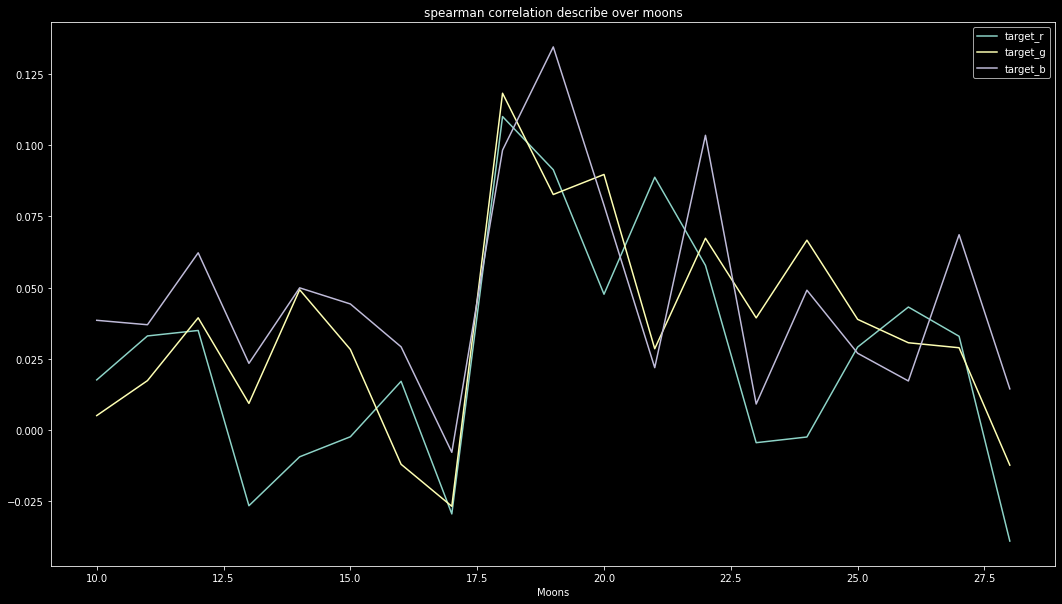

In [22]:
for target in targets:
    title = f'spearman correlation describe over moons'
    # test.groupby('Moons')[target].plot(title=title)
    spearman_cor_results[target].plot(title=title, legend=True, figsize=(18, 10))

### Predict on test set data

In [19]:
X_test

,id,Moons,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_142,Feature_143,Feature_144,Feature_145,Feature_147,Feature_148,Feature_149,Feature_150,Feature_151,Feature_152
0,00030b252d8cccfa4c81b8ef707f7393,0,0.00,0.00,0.25,0.50,0.50,1.00,0.25,0.00,...,0.50,0.25,0.25,0.50,0.25,0.50,0.75,0.00,0.50,0.50
1,000a8d517d41cee44822491c39a19ede,0,0.25,0.25,0.25,0.25,0.25,0.00,0.50,0.00,...,0.50,0.75,0.75,0.50,1.00,0.25,0.75,0.00,0.75,0.50
2,001247d9802556af846a49279d9a5608,0,0.00,0.00,0.75,0.00,0.00,0.50,0.75,0.00,...,0.50,0.25,0.00,0.25,0.25,0.75,0.50,0.50,0.50,0.25
3,002869b312707712e1443cfcb9568948,0,0.75,0.75,0.00,1.00,1.00,0.50,0.00,1.00,...,0.50,0.00,1.00,0.25,0.25,1.00,0.25,1.00,0.00,0.25
4,004b9966e9b8d88d4122b0cf2afe15d7,0,0.50,0.50,1.00,0.75,0.75,1.00,0.00,0.00,...,1.00,0.00,0.75,1.00,0.50,0.75,0.00,0.75,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7198,fedb4f1347e66fbd88a745907beaf609,2,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,...,1.00,1.00,1.00,1.00,1.00,0.50,0.75,0.75,0.50,0.50
7199,fedea2ea3f1ebf8a37f226c57ea54f7d,2,0.00,0.25,0.75,0.25,0.25,1.00,0.50,0.00,...,1.00,0.75,0.50,0.00,0.25,0.50,0.75,0.75,0.50,0.50
7200,ff4f9c3dea9bd93b95894bf38853676a,2,0.50,0.25,0.50,0.50,0.25,0.75,1.00,0.75,...,0.00,0.00,0.00,0.75,0.00,0.00,0.00,0.25,0.75,0.75
7201,ff98a4ab277d6a8f7346a7ee2964233f,2,0.75,0.75,1.00,0.75,0.75,1.00,0.25,1.00,...,1.00,0.25,0.50,0.00,0.25,1.00,0.50,0.50,0.50,0.50


In [20]:
prediction = pd.DataFrame()
for target in targets:
    preds = pd.DataFrame(model[target].predict(X_test.drop(columns=['id', 'Moons'])), columns=[target])
    prediction = pd.concat([prediction, preds], axis=1)

In [21]:
prediction

,target_r,target_g,target_b
0,0.506542,0.506888,0.507720
1,0.505533,0.509252,0.508671
2,0.500215,0.501464,0.498800
3,0.502927,0.503742,0.502526
4,0.500987,0.498064,0.497026
...,...,...,...
7198,0.507606,0.502165,0.503183
7199,0.495785,0.493088,0.490372
7200,0.505757,0.509097,0.510047
7201,0.500441,0.498734,0.498639


### Submit your work

In [ ]:
apiKey = "" # <= API KEY HERE

r = requests.post("https://tournament.crunchdao.com/api/v2/submissions",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": apiKey,
        "comment": "Basic xgb model" # Your comment here
    },
)

if r.status_code == 200:
    print("Submission submitted.")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 409:
    print("ERR: Duplicate submission")
    print("Your work has already been submitted with the same exact results, if you think that this a false positive, contact a cruncher.")
    print("MD5 collision probability: 1/2^128 (source: https://stackoverflow.com/a/288519/7292958)")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")